In [1]:
from gerrychain import Graph

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County and its population in year 2010 was",population)

Node 0 represents Payne County and its population in year 2010 was 77350
Node 1 represents Caddo County and its population in year 2010 was 29600
Node 2 represents Delaware County and its population in year 2010 was 41487
Node 3 represents Marshall County and its population in year 2010 was 15840
Node 4 represents Greer County and its population in year 2010 was 6239
Node 5 represents Coal County and its population in year 2010 was 5925
Node 6 represents Seminole County and its population in year 2010 was 25482
Node 7 represents Murray County and its population in year 2010 was 13488
Node 8 represents Jefferson County and its population in year 2010 was 6472
Node 9 represents Tillman County and its population in year 2010 was 7992
Node 10 represents McIntosh County and its population in year 2010 was 20252
Node 11 represents Choctaw County and its population in year 2010 was 15205
Node 12 represents Harper County and its population in year 2010 was 3685
Node 13 represents Grant County 

In [4]:
# We will instead use 2019 population numbers. Numbers are taken from:
#    https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata-40.csv

population_2019 = {
        'Adair' : 22194,
        'Alfalfa' : 5702,
        'Atoka' : 13758,
        'Beaver' : 5311,
        'Beckham' : 21859,
        'Blaine' : 9429,
        'Bryan' : 47995,
        'Caddo' : 28762,
        'Canadian' : 148306,
        'Carter' : 48111,
        'Cherokee' : 48657,
        'Choctaw' : 14672,
        'Cimarron' : 2137,
        'Cleveland' : 284014,
        'Coal' : 5495,
        'Comanche' : 120749,
        'Cotton' : 5666,
        'Craig' : 14142,
        'Creek' : 71522,
        'Custer' : 29003,
        'Delaware' : 43009,
        'Dewey' : 4891,
        'Ellis' : 3859,
        'Garfield' : 61056,
        'Garvin' : 27711,
        'Grady' : 55834,
        'Grant' : 4333,
        'Greer' : 5712,
        'Harmon' : 2653,
        'Harper' : 3688,
        'Haskell' : 12627,
        'Hughes' : 13279,
        'Jackson' : 24530,
        'Jefferson' : 6002,
        'Johnston' : 11085,
        'Kay' : 43538,
        'Kingfisher' : 15765,
        'Kiowa' : 8708,
        'Latimer' : 10073,
        'Le Flore' : 49853,
        'Lincoln' : 34877,
        'Logan' : 48011,
        'Love' : 10253,
        'McClain' : 40474,
        'McCurtain' : 32832,
        'McIntosh' : 19596,
        'Major' : 7629,
        'Marshall' : 16931,
        'Mayes' : 41100,
        'Murray' : 14073,
        'Muskogee' : 67997,
        'Noble' : 11131,
        'Nowata' : 10076,
        'Okfuskee' : 11993,
        'Oklahoma' : 797434,
        'Okmulgee' : 38465,
        'Osage' : 46963,
        'Ottawa' : 31127,
        'Pawnee' : 16376,
        'Payne' : 81784,
        'Pittsburg' : 43654,
        'Pontotoc' : 38284,
        'Pottawatomie' : 72592,
        'Pushmataha' : 11096,
        'Roger Mills' : 3583,
        'Rogers' : 92459,
        'Seminole' : 24258,
        'Sequoyah' : 41569,
        'Stephens' : 43143,
        'Texas' : 19983,
        'Tillman' : 7250,
        'Tulsa' : 651552,
        'Wagoner' : 81289,
        'Washington' : 51527,
        'Washita' : 10916,
        'Woods' : 8793,
        'Woodward' : 20211                   
}

In [5]:
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    G.nodes[node]['POP19'] = population_2019[name]
    
print("population of Payne County is",G.nodes[0]['POP19'])

population of Payne County is 81784


In [6]:
# what is the total 2019 population?
total_population_2019 = sum( G.nodes[i]['POP19'] for i in G.nodes )

# Let's set lower and upper population bounds on the districts
k = 101              # number of districts
deviation = 0.05     # 5% deviation (+/-2.5%)

import math
L = math.ceil( (1 - deviation / 2) * total_population_2019 / k )
U = math.floor( (1 + deviation / 2) * total_population_2019 / k )

print("Desired number of districts =",k)
print("Lower population threshold =",L)
print("Upper population threshold =",U)

Desired number of districts = 101
Lower population threshold = 38199
Upper population threshold = 40157


In [7]:
# Let's find a large subset of counties B with the property 
#    that every component of G[B] has population less than L.
#
# This is used to help speed up the computations, but has no 
#    bearing on the final results themselves.

import networkx as nx
DG = nx.DiGraph(G) # bidirected version of G

import gurobipy as gp
from gurobipy import GRB

bm = gp.Model()

# X[i,j]=1 if vertex i is assigned to bin j
bX = bm.addVars(DG.nodes, k, vtype=GRB.BINARY) 

# B[i]=1 if vertex i is selected
bB = bm.addVars(DG.nodes, vtype=GRB.BINARY)

# set objective, maximize number of vertices in B
bm.setObjective( gp.quicksum( bB[i] for i in DG.nodes ), GRB.MAXIMIZE )

# relate X and B vars
bm.addConstrs( bB[i] == gp.quicksum( bX[i,j] for j in range(k) ) for i in DG.nodes)

# bin capacity constraints
bm.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * bX[i,j] for i in G.nodes ) <= L-1 for j in range(k) )

# bin conflict constraints
bm.addConstrs( bX[u,j] + bB[v] <= 1 + bX[v,j] for u,v in DG.edges for j in range(k) )

# solve and return B
bm.Params.TimeLimit = 60
bm.optimize()

B = [i for i in DG.nodes if bB[i].x > 0.5]
B_names = [ G.nodes[i]['NAME10'] for i in B ]

print("B =",B)
print("B county names =",B_names)

Academic license - for non-commercial use only - expires 2021-04-22
Using license file C:\Users\buchanan\gurobi.lic
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 39568 rows, 7854 columns and 133801 nonzeros
Model fingerprint: 0x0404caae
Variable types: 0 continuous, 7854 integer (7854 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 24673 rows and 2958 columns
Presolve time: 0.16s
Presolved: 14895 rows, 4896 columns, 53891 nonzeros
Variable types: 0 continuous, 4896 integer (4896 binary)

Root relaxation: objective 4.800000e+01, 5224 iterations, 0.52 seconds

    Nodes    |    Current Node    |     Objective Bo

In [8]:
# function used in sorting step in an upcoming cell
def sort_by_second(val):
    return val[1]   

In [9]:
# Solve county clustering problem:
#
# Group the counties into contiguous clusters so that each has
#   population that is an integer multiple of the ideal population     
#

m = gp.Model()

# X[i,j]=1 if vertex i is assigned to (cluster centered at) vertex j
X = m.addVars(DG.nodes, DG.nodes, vtype=GRB.BINARY) 

# Y[j] = # of clusters centered at vertex j
Y = m.addVars(DG.nodes, vtype=GRB.INTEGER)

# Set objective function, maximize number of clusters
m.setObjective( gp.quicksum( X[j,j] for j in DG.nodes ), GRB.MAXIMIZE ) 

In [10]:
# Add base constraints

# Each county i assigned to one cluster
m.addConstrs( gp.quicksum( X[i,j] for j in DG.nodes ) == 1 for i in DG.nodes )

# Cluster "sizes" should sum to k
m.addConstr( gp.quicksum(Y[j] for j in DG.nodes) == k )

# Population balance: population of cluster j should be in [L,U] * Y[j]
m.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * X[i,j] for i in DG.nodes ) <= U * Y[j] for j in DG.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * X[i,j] for i in DG.nodes ) >= L * Y[j] for j in DG.nodes )

# Enforce relationships between X[i,j] and X[j,j] and Y[j]
m.addConstrs( X[j,j] <= Y[j] for j in DG.nodes )
m.addConstrs( Y[j] <= DG.number_of_nodes() * X[j,j] for j in DG.nodes )
m.addConstrs(X[i,j] <= X[j,j] for i in DG.nodes for j in DG.nodes)

m.update()

In [11]:
# Add contiguity constraints

# F[j,u,v] tells how much flow (from source j) is sent across arc (u,v)
F = m.addVars(DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes() - 1
for j in DG.nodes:
    m.addConstr( sum(F[j,u,j] for u in DG.neighbors(j) ) == 0 )
    for i in DG.nodes:
        if i!=j:
            m.addConstr( sum(F[j,u,i] for u in DG.neighbors(i) ) - sum(F[j,i,u] for u in DG.neighbors(i)) == X[i,j] )
            m.addConstr( sum(F[j,u,i] for u in DG.neighbors(i) ) <= M * X[i,j] )

In [12]:
# This cell: computational speedups 

# Set branch priority on center vars
for j in DG.nodes:
    X[j,j].BranchPriority = 1
    Y[j].BranchPriority = 1
        
# Variable fixing based on set B
V_B_with_population = [(i,G.nodes[i]['POP19']) for i in G.nodes if i not in B]
V_B_with_population.sort(key=sort_by_second,reverse=True)
ordering = [v for (v,p) in V_B_with_population] + B   

# diagonal fixing based on ordering
for p in range(len(ordering)):
    i = ordering[p]
    for q in range(p+1,len(ordering)):
        j = ordering[q]
        X[i,j].UB = 0

# L fixing
for i in DG.nodes:
    for j in B:
        X[i,j].UB = 0

In [13]:
# solve
m.Params.TimeLimit = 7200 # 2-hour time limit
m.optimize()

Changed value of parameter TimeLimit to 7200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18096 rows, 36036 columns and 131044 nonzeros
Model fingerprint: 0xa9c64f99
Variable types: 30030 continuous, 6006 integer (5929 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 11610 rows and 25427 columns
Presolve time: 0.32s
Presolved: 6486 rows, 10609 columns, 40338 nonzeros
Variable types: 8310 continuous, 2299 integer (2249 binary)

Root relaxation: objective 4.356454e+01, 1580 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   43.56454    0  122          -   43.564

 16652  8883   27.87421   26  411   24.00000   27.99641  16.7%  1592 3308s
 17305  9277   26.68162   42  255   24.00000   27.99624  16.7%  1588 3421s
 17979  9613   26.98267   38  291   24.00000   27.99599  16.6%  1580 3539s
 18571 10052   26.91671   29  408   24.00000   27.99566  16.6%  1579 3659s
 19226 10445   27.78204   26  418   24.00000   27.99541  16.6%  1573 3770s
 19862 10870   26.99265   37  250   24.00000   27.99507  16.6%  1568 3898s
 20524 10871   26.45438   43  260   24.00000   27.99496  16.6%  1563 4109s
 20527 10873   27.65728   30  389   24.00000   27.99496  16.6%  1563 4110s
 20529 10874   26.98672   40  451   24.00000   27.73522  15.6%  1563 4117s
 20530 10875   26.98517   44  487   24.00000   27.60124  15.0%  1563 4120s
 20532 10876   25.98282   45  534   24.00000   27.50902  14.6%  1563 4126s
 20534 10878   27.42843   23  525   24.00000   27.42843  14.3%  1562 4131s
 20535 10878   27.39007   35  480   24.00000   27.39007  14.1%  1562 4135s
 20537 10880   26.99604  

 20697 10986   25.00000   62  580   24.00000   26.67254  11.1%  1550 4627s
 20699 10988   26.66894   38  590   24.00000   26.66894  11.1%  1550 4634s
 20700 10988   26.00000   42  599   24.00000   26.66706  11.1%  1550 4636s
 20702 10990   25.71149   44  628   24.00000   26.66539  11.1%  1550 4641s
 20704 10991   26.66444   26  616   24.00000   26.66444  11.1%  1550 4645s
 20707 10993   25.00000   68  572   24.00000   26.66207  11.1%  1549 4653s
 20708 10994   26.66160   40  590   24.00000   26.66160  11.1%  1549 4655s
 20710 10995   25.92961   29  561   24.00000   26.65985  11.1%  1549 4660s
 20712 10996   26.65840   40  564   24.00000   26.65840  11.1%  1549 4666s
 20714 10998   26.65530   34  605   24.00000   26.65530  11.1%  1549 4671s
 20716 10999   25.73232   48  602   24.00000   26.65083  11.0%  1549 4676s
 20718 11000   26.64471   33  596   24.00000   26.64471  11.0%  1549 4683s
 20719 11001   26.64306   25  603   24.00000   26.64306  11.0%  1549 4686s
 20721 11002   26.64019  

 20878 11109   26.45545   39  618   24.00000   26.49706  10.4%  1553 5187s
 20880 11110   25.99269   41  609   24.00000   26.49657  10.4%  1553 5193s
 20881 11111   25.99740   52  570   24.00000   26.49637  10.4%  1553 5196s
 20882 11111   26.49567   30  610   24.00000   26.49567  10.4%  1553 5200s
 20884 11113   26.49501   47  581   24.00000   26.49501  10.4%  1553 5205s
 20886 11114   26.49379   45  626   24.00000   26.49379  10.4%  1552 5211s
 20887 11115   26.49344   29  663   24.00000   26.49344  10.4%  1552 5215s
 20889 11116   26.49186   41  642   24.00000   26.49186  10.4%  1552 5222s
 20891 11117   25.25415   53  684   24.00000   26.49090  10.4%  1552 5229s
 20892 11118   26.27544   34  688   24.00000   26.49040  10.4%  1552 5232s
 20893 11119   26.49002   30  581   24.00000   26.49002  10.4%  1552 5235s
 20895 11120   26.48902   27  672   24.00000   26.48902  10.4%  1552 5242s
 20896 11121   26.48826   52  640   24.00000   26.48826  10.4%  1552 5245s
 20898 11122   26.48732  

 21058 11230   26.42723   36  610   24.00000   26.42723  10.1%  1561 5745s
 21060 11232   26.42670   32  612   24.00000   26.42670  10.1%  1561 5750s
 21062 11233   25.80132   37  565   24.00000   26.42628  10.1%  1561 5755s
 21064 11234   26.42599   25  642   24.00000   26.42599  10.1%  1561 5761s
 21066 11236   26.42583   35  598   24.00000   26.42583  10.1%  1560 5766s
 21068 11237   25.00000   51  628   24.00000   26.42569  10.1%  1560 5770s
 21069 11238   25.00000   53  580   24.00000   26.42553  10.1%  1560 5778s
 21070 11238   26.42545   37  587   24.00000   26.42545  10.1%  1560 5780s
 21072 11240   26.00000   48  598   24.00000   26.42509  10.1%  1560 5785s
 21074 11241   25.49495   42  598   24.00000   26.42496  10.1%  1560 5790s
 21076 11242   26.42483   40  584   24.00000   26.42483  10.1%  1560 5795s
 21078 11244   26.42470   39  570   24.00000   26.42470  10.1%  1559 5800s
 21079 11244   26.42464   29  622   24.00000   26.42464  10.1%  1559 5806s
 21081 11246   25.99740  

 21248 11359   26.39298   25  666   24.00000   26.39298  10.0%  1566 6295s
 21250 11360   26.39261   51  667   24.00000   26.39261  10.0%  1565 6302s
 21251 11361   26.39244   24  624   24.00000   26.39244  10.0%  1565 6305s
 21254 11363   26.00000   50  659   24.00000   26.39179  10.0%  1565 6312s
 21255 11363   25.99275   39  679   24.00000   26.39166  10.0%  1565 6318s
 21256 11364   26.39144   38  637   24.00000   26.39144  10.0%  1565 6321s
 21258 11365   26.39103   36  636   24.00000   26.39103  10.0%  1565 6325s
 21260 11367   26.39067   32  673   24.00000   26.39067  10.0%  1565 6336s
 21262 11368   25.80132   37  669   24.00000   26.39050  10.0%  1565 6341s
 21264 11369   26.39031   25  671   24.00000   26.39031  10.0%  1564 6346s
 21265 11370   25.00000   51  650   24.00000   26.39025  10.0%  1564 6353s
 21266 11371   26.39011   35  663   24.00000   26.39011  10.0%  1564 6356s
 21267 11371   25.98701   41  660   24.00000   26.39007  10.0%  1564 6362s
 21269 11373   25.00000  

 21442 11490   26.37130   34  612   24.00000   26.37130  9.88%  1569 6851s
 21444 11491   26.37127   33  623   24.00000   26.37127  9.88%  1568 6855s
 21447 11493   26.37094   43  616   24.00000   26.37094  9.88%  1568 6862s
 21449 11494   25.99330   46  595   24.00000   26.37079  9.88%  1568 6866s
 21451 11496   26.37059   24  597   24.00000   26.37059  9.88%  1568 6871s
 21453 11497   26.37034   28  585   24.00000   26.37034  9.88%  1568 6877s
 21455 11498   25.99275   39  602   24.00000   26.37001  9.88%  1568 6882s
 21456 11499   26.36999   38  624   24.00000   26.36999  9.87%  1568 6885s
 21458 11500   26.36979   36  595   24.00000   26.36979  9.87%  1567 6891s
 21460 11502   26.36962   32  582   24.00000   26.36962  9.87%  1567 6897s
 21461 11502   25.95354   48  590   24.00000   26.36957  9.87%  1567 6900s
 21463 11504   26.36943   34  580   24.00000   26.36943  9.87%  1567 6905s
 21465 11505   25.00000   51  572   24.00000   26.36926  9.87%  1567 6910s
 21467 11506   25.98701  

In [17]:
# What are the cluster "centers"?
centers = [j for j in DG.nodes if Y[j].x > 0.5]

print("********************************")
print("********************************")

# Print info about each cluster
clusters = list()
for j in centers:
    cluster_nodes = [ i for i in DG.nodes if X[i,j].x > 0.5 ]
    cluster_names = [ G.nodes[i]['NAME10'] for i in cluster_nodes ]
    cluster_population = sum( G.nodes[node]['POP19'] for node in cluster_nodes )
    cluster_size = int(Y[j].x)
    print("Cluster rooted at node",j,"(",G.nodes[j]['NAME10']," County ) has total population",cluster_population,"and should be split into",cluster_size,"district(s).")
    print("Cluster nodes are",cluster_nodes,"which correspond to counties:",cluster_names)
    print("Average district in this cluster should have population",cluster_population/cluster_size)
    print("********************************")
    print("********************************")
    clusters.append(cluster_nodes)
    
print("There are",len(clusters),"clusters:",clusters)

********************************
********************************
Cluster rooted at node 0 ( Payne  County ) has total population 153306 and should be split into 4 district(s).
Cluster nodes are [0, 57] which correspond to counties: ['Payne', 'Creek']
Average district in this cluster should have population 38326.5
********************************
********************************
Cluster rooted at node 1 ( Caddo  County ) has total population 39678 and should be split into 1 district(s).
Cluster nodes are [1, 56] which correspond to counties: ['Caddo', 'Washita']
Average district in this cluster should have population 39678.0
********************************
********************************
Cluster rooted at node 2 ( Delaware  County ) has total population 115236 and should be split into 3 district(s).
Cluster nodes are [2, 36, 43] which correspond to counties: ['Delaware', 'Mayes', 'Ottawa']
Average district in this cluster should have population 38412.0
*******************************

In [15]:
# Map the clusters
import geopandas as gpd

filepath = 'C:\\districting-data\\'
filename = 'OK_county.shp'
df = gpd.read_file( filepath + filename )

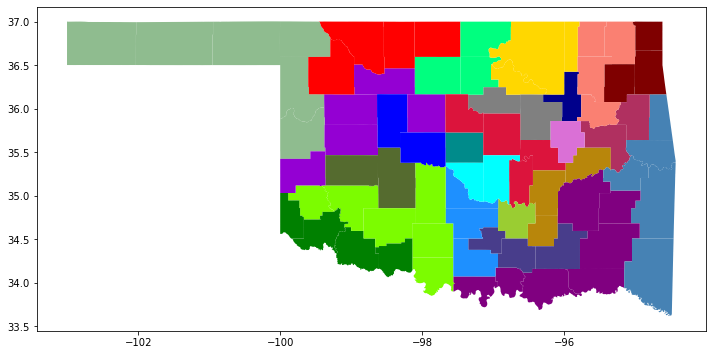

In [16]:
# Which cluster is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(clusters)):
    
    # for each node i in this cluster
    for i in clusters[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
pallette = ['#808080','#556b2f','#7f0000','#483d8b','#008000','#b8860b','#008b8b','#4682b4','#9acd32','#00008b','#8fbc8f','#800080','#b03060','#ff0000','#ffd700','#7cfc00','#9400d3','#00ff7f','#dc143c','#00ffff','#0000ff','#da70d6','#1e90ff','#fa8072','#90ee90','#add8e6','#ff1493','#7b68ee','#ffdead','#ffb6c1']
colors = [pallette[assignment[node]] for node in G.nodes]
df['colors'] = colors
my_fig = df.plot(color=df['colors']).get_figure()
RESIZE_FACTOR = 2
my_fig.set_size_inches(my_fig.get_size_inches()*RESIZE_FACTOR)

In [18]:
# The county clusters can be split in many, many ways. Here is one possible way
import webbrowser

webbrowser.open('https://davesredistricting.org/join/bafda10a-134e-438b-a36b-38456ee0a53c')  

True